In [1]:
import os
import torch
import torch.nn as nn 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU index

print("Available GPUs:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

Available GPUs: 1
GPU 0: Quadro P2000
cuda:0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch 
import sys
sys.path.insert(1, os.path.join("..", "data"))
sys.path.insert(1, os.path.join("..", "utils"))
from data_utils import Dataset
from plot_utils import plot_image
from torch.utils.data import DataLoader

In [4]:
# Path to the data folder (update the variable to your path).
path_data=os.path.join("..", "data")
# Seed value
seed=1001

In [5]:
dataset=Dataset(path_data=path_data, seed=seed)
dataset.read_data()
dataset.get_statistics()

Parsing class: Cloud: 143it [00:10, 14.27it/s]
Parsing class: Edge: 97it [00:05, 16.86it/s]
Parsing class: Good: 64it [00:04, 13.07it/s]


train  valid  test
cloud    100     24    19
edge      64     15    18
good      48      7     9

In [6]:
batch_size=32
# Train loader
train_loader = DataLoader(dataset.get_split("train"), batch_size=batch_size, pin_memory=False, shuffle=True)
# Cross validation data loader
valid_loader = DataLoader(dataset.get_split("valid"), batch_size=batch_size, pin_memory=False, shuffle=True)
# Test data loader
test_loader = DataLoader(dataset.get_split("test"), batch_size=batch_size, pin_memory=False, shuffle=True)

In [7]:
classes = ('cloud', 'edge', 'good')

Start of training loop

In [8]:
import torch.nn.functional as F 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def resize_tensor_images(images, size=(256, 256)):
    # Resize the batch of images
    return F.interpolate(images, size=size, mode='bilinear', align_corners=False)

def compute_mean_std(loader):
    # Computation of mean and standard deviation of batches
    mean = 0.
    std = 0.
    total_images_count = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

def normalize_images(images, mean, std):
    # Normalizing images with previously computed mean and standard deviation
    normalized_images = (images - mean.view(-1, 1, 1)) / std.view(-1, 1, 1)
    return normalized_images
    
def tensor_to_numpy(tensor):
    # Rescale the tensor to 0-1 range
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    # Move the tensor to CPU if it's on GPU
    tensor = tensor.cpu()
    # Convert to numpy and transpose from CxHxW to HxWxC for visualization
    numpy_image = tensor.numpy()
    numpy_image = np.transpose(numpy_image, (1, 2, 0))

    return numpy_image

In [9]:
mean, std = compute_mean_std(test_loader)

In [10]:
def normalization(data_loader, mean, std):
    UNPRO_batches = []
    batches = []
    
    for batch in data_loader:
        images, labels = batch
        resized_images = resize_tensor_images(images)
        UNPRO_batches.append((resized_images, labels))
        normalized_alldata_images = normalize_images(resized_images, mean, std)

        # Append the normalized images and their corresponding labels to the list
        batches.append((normalized_alldata_images, labels))
    return UNPRO_batches, batches

UNPRO_batches_TRL, batches_TRL = normalization(train_loader, mean, std)
UNPRO_batches_VAL, batches_VAL = normalization(valid_loader, mean, std)
UNPRO_batches_TST, batches_TST = normalization(test_loader, mean, std)


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 25, kernel_size=3, padding=1),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.Conv2d(25, 25, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(25, 25, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(25, 25, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=409600,
                      out_features=3)
        )
    def forward(self, x):

        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.classifier(x)

        return x
    
net = Net().to(device)

In [12]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [13]:
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=3).to(device)

In [14]:
def train_step(model: torch.nn.Module,
               batches,
               loss_fn,
               optimizer,
               accuracy,
               device: torch.device = device):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (images, labels) in enumerate(batches, 0):
        
        images, labels = images.to(device), labels.to(device)

        y_logits = model(images)

        # Calculate loss on 1 batch of data
        loss = loss_fn(y_logits, labels)
        acc = accuracy(y_logits.argmax(dim=-1), labels)
        train_loss += loss
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_acc = train_acc / len(batches)
    train_loss = train_loss / len(batches)

    print(f"Train Loss: {train_loss:.4f}, Training Accuracy: {train_acc*100:.4f}")
    return train_acc, train_loss.cpu().detach().numpy()

In [15]:
def validation_step(model,
              batches,
              loss_fn,
              accuracy,
              device: torch.device = device):
    validation_loss, validation_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for images_validation, labels_validation in batches:
            images_validation, labels_validation = images_validation.to(device), labels_validation.to(device)
            
            validation_logits = model(images_validation)
            validation_loss += loss_fn(validation_logits, labels_validation)
            validation_acc += accuracy(validation_logits.argmax(dim=-1), labels_validation)

        validation_loss /= len(batches)
        validation_acc /= len(batches)
    print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc*100:.4f}%")
    return validation_acc, validation_loss.cpu().detach().numpy()

In [16]:
def test_step(model,
              batches,
              loss_fn,
              accuracy,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for images_test, labels_test in batches:
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            
            test_logits = model(images_test)
            test_loss += loss_fn(test_logits, labels_test)
            test_acc += accuracy(test_logits.argmax(dim=-1), labels_test)

        test_loss /= len(batches)
        test_acc /= len(batches)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.4f}%")
    return test_acc, test_loss.cpu()

In [17]:
from tqdm.auto import tqdm
epochs = 10
train_losses = []
val_losses = []

for epoch in tqdm(range(epochs)):
    _, train_loss = train_step(model=net,
               batches=batches_TRL,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy=accuracy_fn,
               device=device
               )
    _, val_loss = validation_step(model=net,
              batches=batches_VAL,
              loss_fn=loss_fn,
              accuracy=accuracy_fn,
              device=device)
    test_step(model=net,
              batches=batches_TST,
              loss_fn=loss_fn,
              accuracy=accuracy_fn,
              device=device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 1.0899, Training Accuracy: 39.4643
Validation Loss: 1.0331, Validation Accuracy: 51.5625%
Test Loss: 1.0816, Test Accuracy: 37.7232%
Train Loss: 1.0566, Training Accuracy: 47.0536
Validation Loss: 0.9931, Validation Accuracy: 51.5625%
Test Loss: 1.0646, Test Accuracy: 37.7232%
Train Loss: 1.0322, Training Accuracy: 47.0536
Validation Loss: 0.9754, Validation Accuracy: 51.5625%
Test Loss: 1.0256, Test Accuracy: 37.7232%
Train Loss: 1.0078, Training Accuracy: 57.0536
Validation Loss: 0.9670, Validation Accuracy: 66.5179%
Test Loss: 0.9937, Test Accuracy: 60.2679%
Train Loss: 0.9852, Training Accuracy: 63.3036
Validation Loss: 0.9564, Validation Accuracy: 61.3839%
Test Loss: 0.9740, Test Accuracy: 62.2768%
Train Loss: 0.9604, Training Accuracy: 62.8571
Validation Loss: 0.9369, Validation Accuracy: 62.9464%
Test Loss: 0.9480, Test Accuracy: 62.2768%
Train Loss: 0.9331, Training Accuracy: 65.5357
Validation Loss: 0.9162, Validation Accuracy: 61.3839%
Test Loss: 0.9152, Test Accu

In [18]:
# layer_info = '-'.join(map(str, layer_sizes[:-1]))
txt = './e{}_b{}_s{}.pth'.format(epochs, batch_size, seed)
PATH = txt
# PATH = './test1.pth'
torch.save(net.state_dict(), PATH)

net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
def concatenate_batches(batches):
    images_norm = torch.tensor([])
    for i, batch in enumerate(batches):
        images_batch, labels_batch = batch
        if i == 0:
            images_norm = images_batch
            labels_norm = labels_batch
        else:
            images_norm = torch.cat((images_norm, images_batch))
            labels_norm = torch.cat((labels_norm, labels_batch))
    return images_norm, labels_norm

images_norm_TRL, labels_norm_TRL = concatenate_batches(batches_TRL)
images_norm_VAL, labels_norm_VAL = concatenate_batches(batches_VAL)
images_norm_TST, labels_norm_TST = concatenate_batches(batches_TST)

images_og_TST, labels_og_TST = concatenate_batches(UNPRO_batches_TST)

In [20]:
net.to('cpu')

outputs_TST = net(images_norm_TST.to('cpu'))

In [21]:
_, predicted_TST = torch.max(outputs_TST, 1)

predictions_TST = [classes[predicted_TST[j]] for j in range(46)]

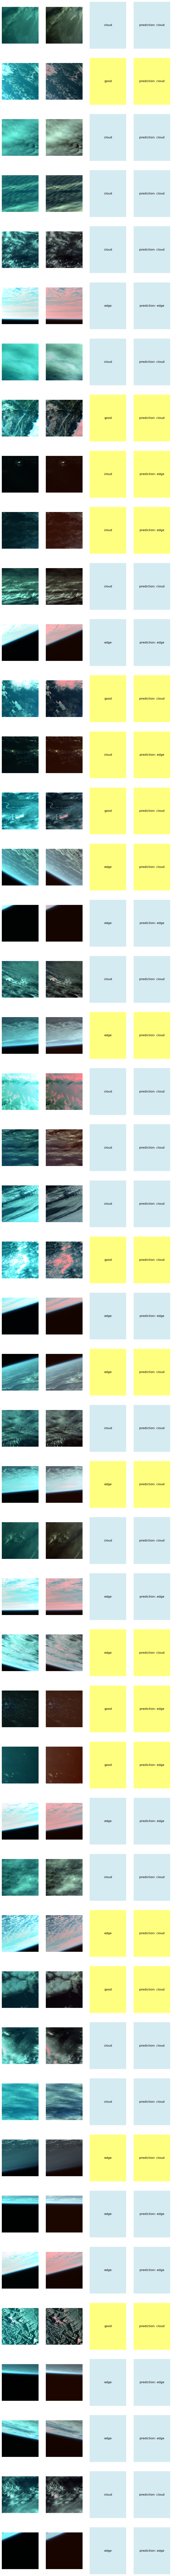

In [22]:
fig, axs = plt.subplots(46, 4, figsize=(12, 4 * 46))

for i in range(len(images_norm_TST)):
    og_img = tensor_to_numpy(images_og_TST[i])
    norm_img = tensor_to_numpy(images_norm_TST[i])
    
    axs[i, 0].imshow(og_img)
    axs[i, 0].axis('off')

    # Plot the second image
    axs[i, 1].imshow(norm_img)  # Assuming there are always pairs of images
    axs[i, 1].axis('off')

    # Plot the first text box
    axs[i, 2].text(0.5, 0.5, classes[labels_norm_TST[i]], ha='center', va='center', fontsize=12, color='black')
    axs[i, 2].axis('off')

    # Plot the second text box
    axs[i, 3].text(0.5, 0.5, 'prediction: ' + str(predictions_TST[i]), ha='center', va='center', fontsize=12, color='black')
    axs[i, 3].axis('off')
# plt.tight_layout()
    # plt.tight_layout()
    if predictions_TST[i] == classes[labels_norm_TST[i]]:
        row_color = 'lightblue'  # Set to blue if the condition is true
    else:
        row_color = 'yellow'  # Set to yellow if the condition is false

    rect = patches.Rectangle((0, 0), 1, 1, linewidth=0, edgecolor='none', facecolor=row_color, alpha=0.5)
    axs[i, 0].add_patch(rect)
    axs[i, 1].add_patch(patches.Rectangle((0, 0), 1, 1, linewidth=0, edgecolor='none', facecolor=row_color, alpha=0.5))
    axs[i, 2].add_patch(patches.Rectangle((0, 0), 1, 1, linewidth=0, edgecolor='none', facecolor=row_color, alpha=0.5))
    axs[i, 3].add_patch(patches.Rectangle((0, 0), 1, 1, linewidth=0, edgecolor='none', facecolor=row_color, alpha=0.5))

# plt.show()

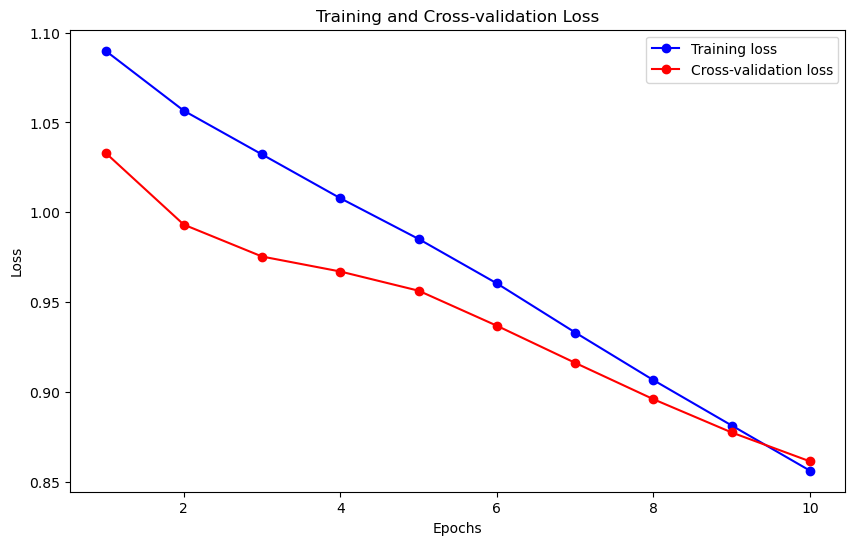

In [24]:
epochs = range(1, len(train_losses) + 1)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Cross-validation loss')
plt.title('Training and Cross-validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()